In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastparquet
import dask.dataframe as dd
from utils import pipe_newb,pipe_broken,pipe_rental
import koreanize_matplotlib
from scipy import stats

c:\Users\chane\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
#df = dd.read_parquet('rental.parquet',engine='pyarrow')

In [5]:
df = dd.read_parquet('rental.parquet',engine='pyarrow')
df = df.compute()
df = pipe_rental(df)

In [6]:
#df = df.sample(frac=0.3, random_state=42)

In [7]:
#df = df.compute()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634819 entries, 0 to 1634818
Data columns (total 9 columns):
 #   Column   Non-Null Count    Dtype         
---  ------   --------------    -----         
 0   자전거번호    1634819 non-null  string        
 1   대여일시     1634819 non-null  datetime64[ns]
 2   이용시간(분)  1634819 non-null  int64         
 3   이용거리(M)  1634819 non-null  float64       
 4   생년       1634819 non-null  string        
 5   이용자종류    1634819 non-null  string        
 6   대여대여소ID  1634819 non-null  string        
 7   반납대여소ID  1634819 non-null  string        
 8   나이(만)    1634819 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), string(5)
memory usage: 130.7 MB


In [9]:
df.shape

(1634819, 9)

## 전처리 내역
df_rental (대여이력정보)
- ‘생년’ 항목에 결측치(’\N’) 행삭제 (3,717,287개)
- 파생변수 ‘나이’ 를 만들어 만 14세이상 65세미만 데이터 사용
- 이용자 종류 중 외국인 제외 (78,506개)

- 이용시간(분), 이용거리(M) 이 0인경우 오류 → 포함되면 행삭제
- 주제에 맞게 이용거리(M), 이용시간(분) 기준 정하기
→ 이용거리(M) 1km(1000m)이상 … 100km(100000m)이하
→ 이용시간(분) 5분이상 60분이하

- 반납시간은 있는데 반납대여소ID가 없는경우 강제반납 (분실,,,등)
→ 분실처리!

'생년' 항복에 결측치 ('\\N' 행 삭제)

In [10]:
df = df[df['생년'] != '\\N']
count_n = df['생년'].str.contains(r'\\N', regex=False).sum()
print(count_n)

0


파생변수 ‘나이’ 를 만들어 만 14세이상 65세미만 데이터 사용 

In [11]:
df['대여일시'] = pd.to_datetime(df['대여일시'])
df['나이'] = df['대여일시'].dt.year - df['생년'].astype('int64')

In [12]:
df = df[(df['나이'] >= 14) & (df['나이'] <= 64)]
df.shape

(1634819, 10)

이용자 종류 중 외국인 제외

In [13]:
df = df[df['이용자종류'] != '외국인']
df.shape

(1634819, 10)

이용시간(분), 이용거리(M) 이 0인경우 오류 → 포함되면 행삭제

In [14]:
df = df[(df['이용시간(분)'] > 0) & (df['이용거리(M)'] > 0)]
df.shape

(1634819, 10)

In [15]:
distance_condition = (df['이용거리(M)'] >= 1000) & (df['이용거리(M)'] <= 15000)
time_condition = (df['이용시간(분)'] >= 5) & (df['이용시간(분)'] <= 60)
df = df[distance_condition & time_condition]
df.shape

(1634819, 10)

In [16]:
df = df[df['반납대여소ID'] != '\\N']
df.shape

(1634819, 10)

## 2022년도와 2023년도 이용내역 비교
사용할 변수 = 대여일시,자전거번호
방법: 두 년도의 7-12월의 그래프를 만들어 비교하여 대중교통 요금 인상이 실질적인 사용량에 영향을 줬는지를 보기 위함

In [17]:
cols = ['대여일시','자전거번호']
df_22 = df[df['대여일시'].dt.year == 2022]
df_23 = df[df['대여일시'].dt.year == 2023]

In [18]:
df_23 = df_23[cols]
df_22 = df_22[cols]

In [19]:
df_22['year']  = df_22['대여일시'].dt.year
df_22['month']  = df_22['대여일시'].dt.month
df_22.head()

,대여일시,자전거번호,year,month
1,2022-07-14 10:57:05,SPB-57723,2022,7
2,2022-07-29 19:30:56,SPB-46377,2022,7
3,2022-08-16 09:27:34,SPB-36269,2022,8
6,2022-12-22 21:18:16,SPB-58589,2022,12
7,2022-09-18 00:12:51,SPB-34119,2022,9


In [20]:
df_23['year']  = df_23['대여일시'].dt.year
df_23['month']  = df_23['대여일시'].dt.month
df_23.head()

,대여일시,자전거번호,year,month
0,2023-08-04 08:20:58,SPB-55182,2023,8
4,2023-07-01 09:53:56,SPB-50333,2023,7
5,2023-11-23 13:53:51,SPB-37907,2023,11
8,2023-10-23 23:13:54,SPB-66765,2023,10
9,2023-09-12 00:18:15,SPB-55114,2023,9


In [21]:
monthly_counts_22 = df_22.groupby(['year', 'month']).size().reset_index(name='count')
print(monthly_counts_22)

   year  month   count
0  2022      7  147510
1  2022      8  129666
2  2022      9  174749
3  2022     10  162814
4  2022     11  137498
5  2022     12   59758


In [22]:
monthly_counts_23 = df_23.groupby(['year', 'month']).size().reset_index(name='count')
print(monthly_counts_23)

   year  month   count
0  2023      7  139512
1  2023      8  137982
2  2023      9  164562
3  2023     10  193638
4  2023     11  115543
5  2023     12   71587


C:\Users\chane\AppData\Local\Temp\ipykernel_29580\1794673116.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=monthly_counts_22, x='month', y='count', marker='o',ci=None)


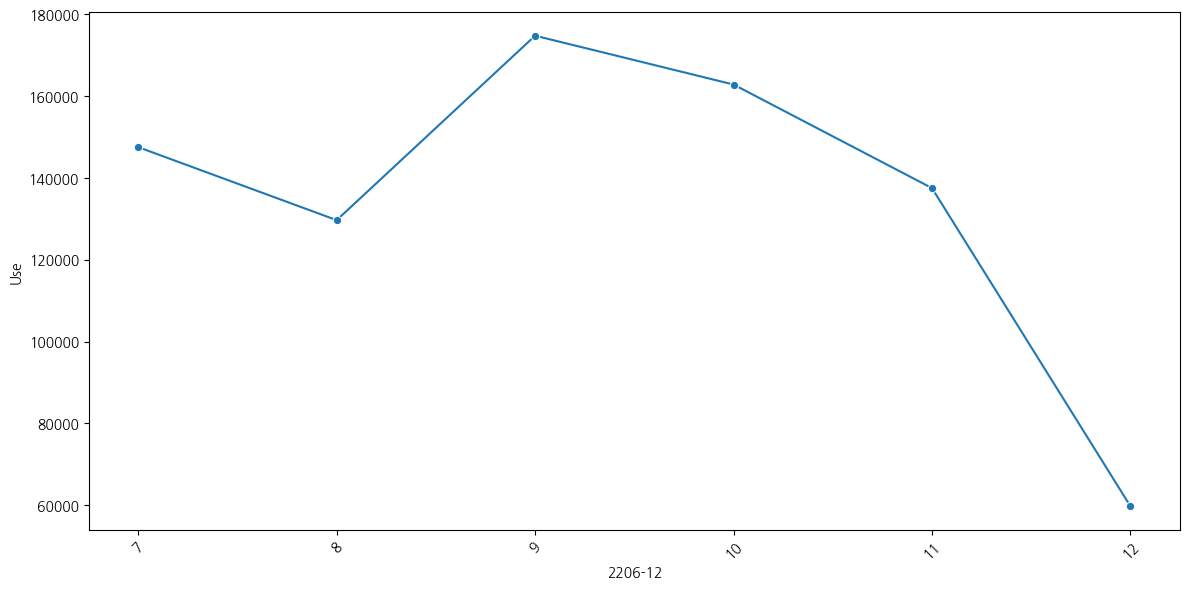

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts_22, x='month', y='count', marker='o',ci=None)
plt.xlabel('2206-12')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\chane\AppData\Local\Temp\ipykernel_29580\2364743078.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=monthly_counts_23, x='month', y='count', marker='o',ci=None)


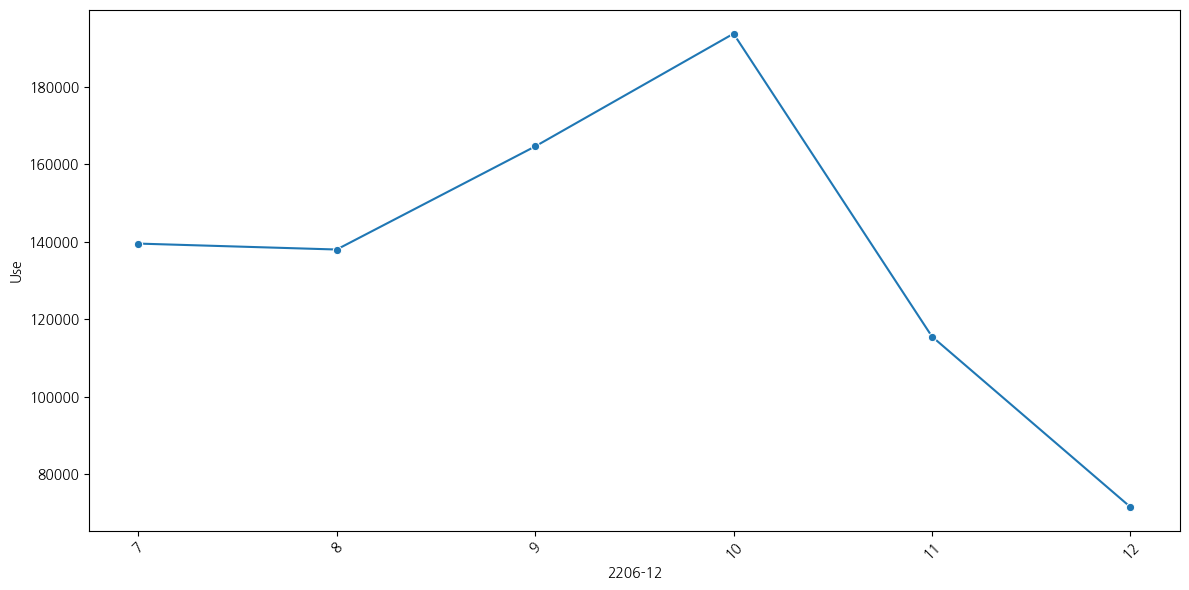

In [24]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts_23, x='month', y='count', marker='o',ci=None)
plt.xlabel('2206-12')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
montly_combined = pd.concat([monthly_counts_22,monthly_counts_23])
montly_combined

,year,month,count
0,2022,7,147510
1,2022,8,129666
2,2022,9,174749
3,2022,10,162814
4,2022,11,137498
5,2022,12,59758
0,2023,7,139512
1,2023,8,137982
2,2023,9,164562
3,2023,10,193638


C:\Users\chane\AppData\Local\Temp\ipykernel_29580\2337932849.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=montly_combined, x='month', y='count', hue='year', marker='o', ci=None)


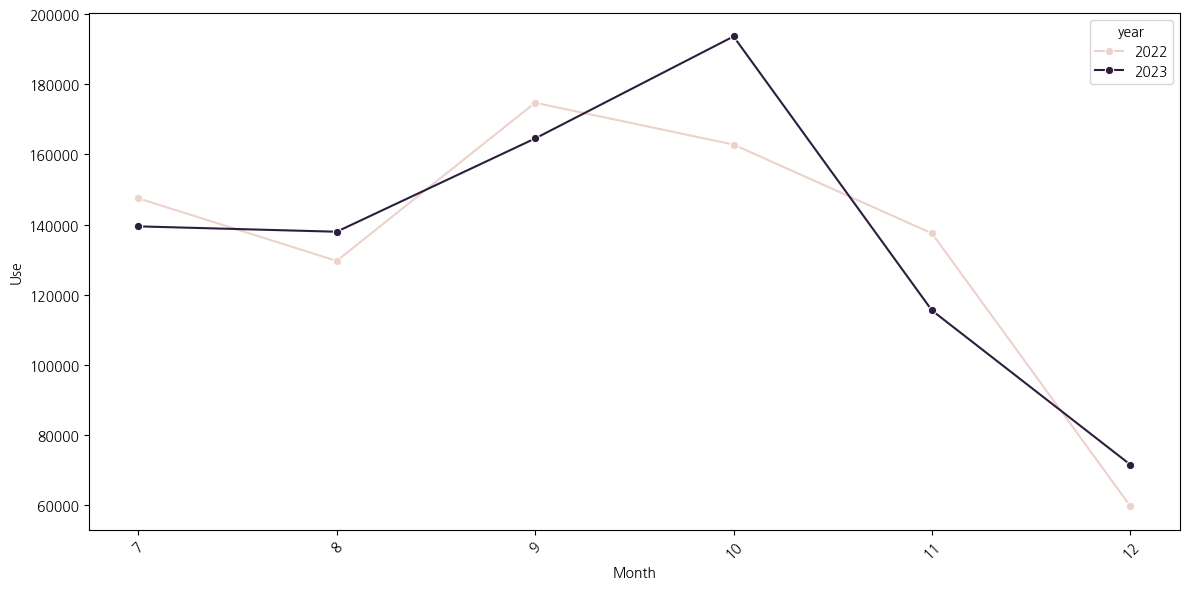

In [26]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=montly_combined, x='month', y='count', hue='year', marker='o', ci=None)

plt.xlabel('Month')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

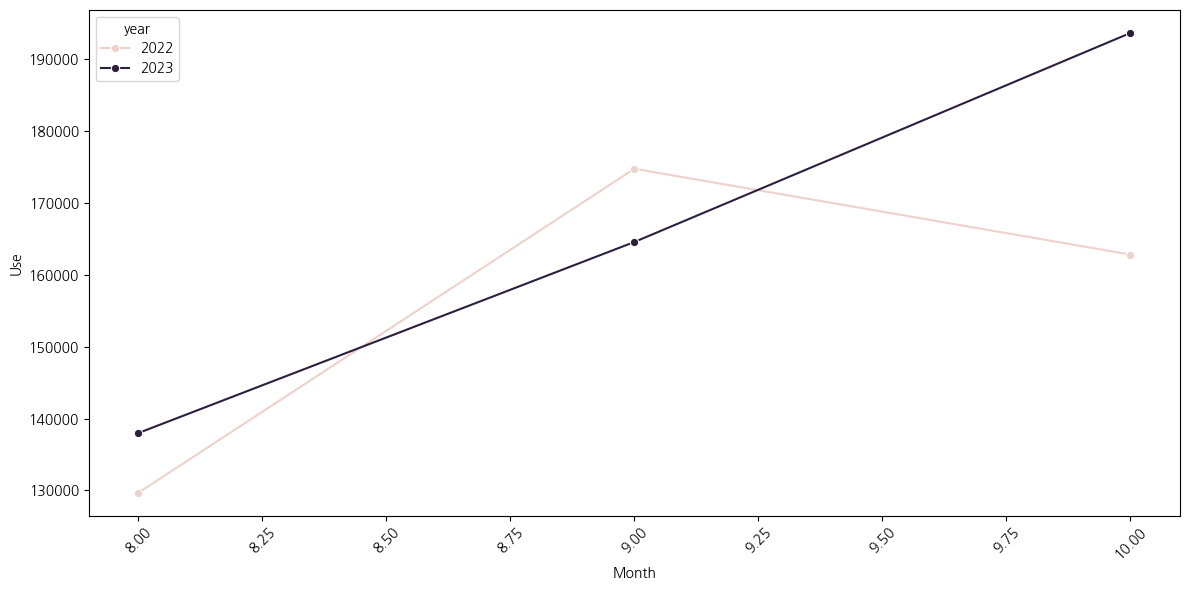

In [27]:
filtered_data = montly_combined.query('8 <= month <= 10')
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='month', y='count', hue='year', marker='o')
plt.xlabel('Month')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [28]:
def calculate_monthly_increase(df):
    # 연도별로 그룹화하고 월별 데이터 개수 집계
    df['증가폭'] = df.groupby('year')['count'].diff().fillna(0)
    return df

In [29]:
monthly_counts_22 = calculate_monthly_increase(monthly_counts_22)
monthly_counts_23 = calculate_monthly_increase(monthly_counts_23)

In [30]:
monthly_counts_22

,year,month,count,증가폭
0,2022,7,147510,0.0
1,2022,8,129666,-17844.0
2,2022,9,174749,45083.0
3,2022,10,162814,-11935.0
4,2022,11,137498,-25316.0
5,2022,12,59758,-77740.0


In [31]:
monthly_counts_23

,year,month,count,증가폭
0,2023,7,139512,0.0
1,2023,8,137982,-1530.0
2,2023,9,164562,26580.0
3,2023,10,193638,29076.0
4,2023,11,115543,-78095.0
5,2023,12,71587,-43956.0


## 고장 신고 내역 비교
- 월별 고장 수를 기준으로 데이터를 로드하고 월별 집계

In [32]:
broken_22 = pd.read_csv('Data\원본\고장신고내역(일별)_2207-12.csv')
broken_23 = pd.read_csv('Data\원본\고장신고내역(일별)_2307-12.csv')

In [33]:
df['대여일시'] = pd.to_datetime(df['대여일시'])
df['년도'] = df['대여일시'].dt.year
df['월'] = df['대여일시'].dt.month
df['일'] = df['대여일시'].dt.day

In [34]:
df.head()

,자전거번호,대여일시,이용시간(분),이용거리(M),생년,이용자종류,대여대여소ID,반납대여소ID,나이(만),나이,년도,월,일
0,SPB-55182,2023-08-04 08:20:58,24,3215.33,1991,내국인,ST-1968,ST-1677,32,32,2023,8,4
1,SPB-57723,2022-07-14 10:57:05,13,1483.24,1993,내국인,ST-2428,ST-1337,29,29,2022,7,14
2,SPB-46377,2022-07-29 19:30:56,51,1830.00,1991,내국인,ST-206,ST-1173,31,31,2022,7,29
3,SPB-36269,2022-08-16 09:27:34,35,4049.77,1982,내국인,ST-2874,ST-2874,40,40,2022,8,16
4,SPB-50333,2023-07-01 09:53:56,7,1285.90,1973,내국인,ST-1818,ST-2229,50,50,2023,7,1


In [35]:
broken_22.head()

,자전거번호,등록일시,고장구분
0,SPB-30229,2022-07-01 00:44:33,페달
1,SPB-40134,2022-07-01 00:57:59,페달
2,SPB-40789,2022-07-01 01:08:25,안장
3,SPB-50932,2022-07-01 01:09:33,체인
4,SPB-41175,2022-07-01 01:13:06,안장


In [36]:
broken_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105550 entries, 0 to 105549
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   자전거번호   105550 non-null  object
 1   등록일시    105550 non-null  object
 2   고장구분    105550 non-null  object
dtypes: object(3)
memory usage: 2.4+ MB


In [37]:
broken_22['등록일시'] = pd.to_datetime(broken_22['등록일시'])
broken_23['등록일시'] = pd.to_datetime(broken_23['등록일시'])

In [38]:
broken_22['년도'] = broken_22['등록일시'].dt.year
broken_22['월'] = broken_22['등록일시'].dt.month
broken_22['일'] = broken_22['등록일시'].dt.day
broken_22.head()

,자전거번호,등록일시,고장구분,년도,월,일
0,SPB-30229,2022-07-01 00:44:33,페달,2022,7,1
1,SPB-40134,2022-07-01 00:57:59,페달,2022,7,1
2,SPB-40789,2022-07-01 01:08:25,안장,2022,7,1
3,SPB-50932,2022-07-01 01:09:33,체인,2022,7,1
4,SPB-41175,2022-07-01 01:13:06,안장,2022,7,1


In [39]:
broken_23['년도'] = broken_23['등록일시'].dt.year
broken_23['월'] = broken_23['등록일시'].dt.month
broken_23['일'] = broken_23['등록일시'].dt.day
broken_23.head()

,자전거번호,등록일시,고장구분,년도,월,일
0,SPB-49493,2023-07-01 00:02:28,기타,2023,7,1
1,SPB-34078,2023-07-01 00:08:20,기타,2023,7,1
2,SPB-65202,2023-07-01 00:13:55,타이어,2023,7,1
3,SPB-62031,2023-07-01 00:14:27,타이어,2023,7,1
4,SPB-37479,2023-07-01 00:21:21,타이어,2023,7,1


In [40]:
broken_counts_2022 = broken_22[(broken_22['년도'] == 2022) & (broken_22['월'] >= 7)].groupby(['년도', '월']).size().reset_index(name='고장횟수')
broken_counts_2023 = broken_23[(broken_23['년도'] == 2023) & (broken_23['월'] >= 7)].groupby(['년도', '월']).size().reset_index(name='고장횟수')
broken_counts_2022

,년도,월,고장횟수
0,2022,7,18127
1,2022,8,17345
2,2022,9,24000
3,2022,10,20936
4,2022,11,16124
5,2022,12,9018


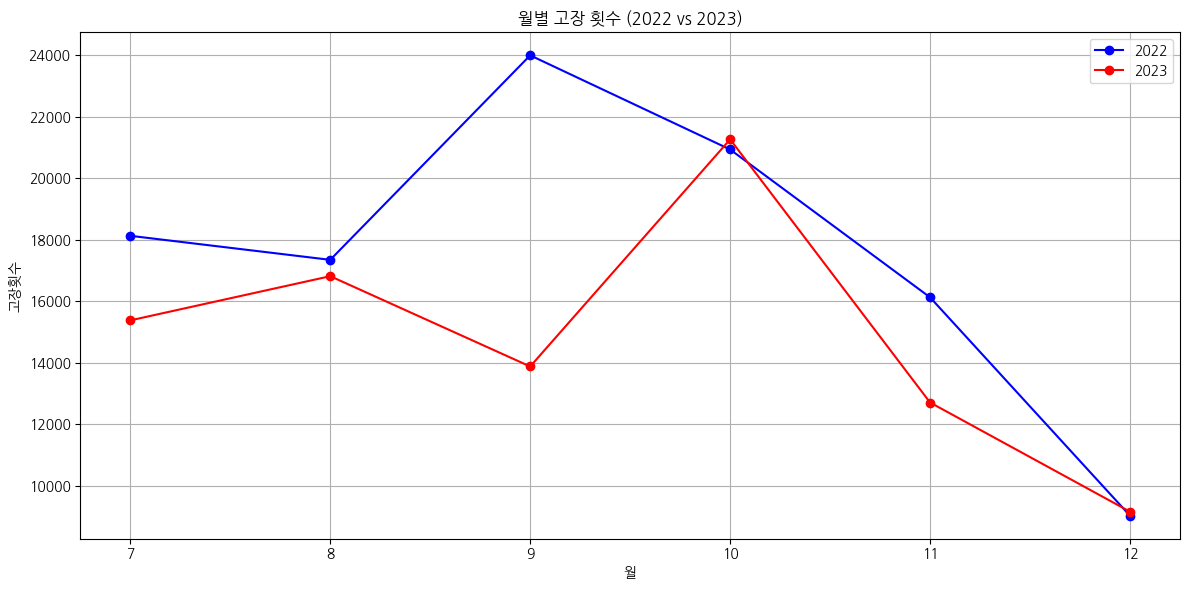

In [41]:
plt.figure(figsize=(12, 6))

plt.plot(broken_counts_2022['월'], broken_counts_2022['고장횟수'], marker='o', linestyle='-', color='b', label='2022')
plt.plot(broken_counts_2023['월'], broken_counts_2023['고장횟수'], marker='o', linestyle='-', color='r', label='2023')

plt.xlabel('월')
plt.ylabel('고장횟수')
plt.title('월별 고장 횟수 (2022 vs 2023)')
plt.legend()
plt.grid(True)

plt.xticks(range(7, 13))  # 7월부터 12월까지 표시
plt.tight_layout()

plt.show()

In [42]:
rental_counts_2022 = df[(df['년도'] == 2022) & (df['월'] >= 7)].groupby(['년도', '월']).size().reset_index(name='이용건수')
rental_counts_2023 = df[(df['년도'] == 2023) & (df['월'] >= 7)].groupby(['년도', '월']).size().reset_index(name='이용건수')
rental_counts_2022

,년도,월,이용건수
0,2022,7,147510
1,2022,8,129666
2,2022,9,174749
3,2022,10,162814
4,2022,11,137498
5,2022,12,59758


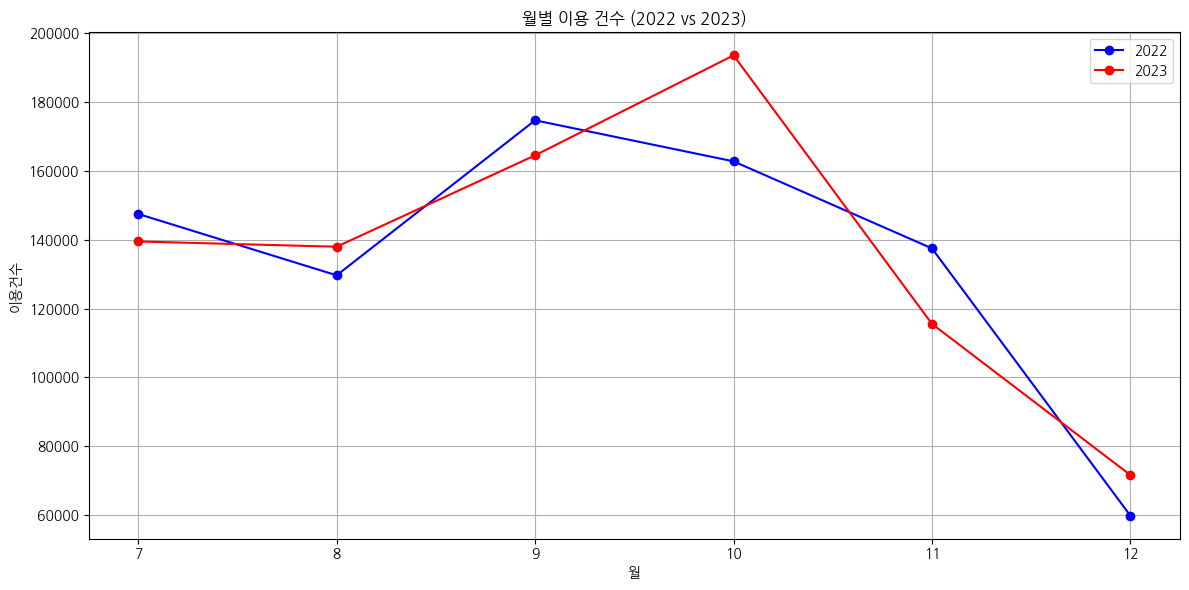

In [43]:
plt.figure(figsize=(12, 6))

plt.plot(rental_counts_2022['월'], rental_counts_2022['이용건수'], marker='o', linestyle='-', color='b', label='2022')
plt.plot(rental_counts_2023['월'], rental_counts_2023['이용건수'], marker='o', linestyle='-', color='r', label='2023')

plt.xlabel('월')
plt.ylabel('이용건수')
plt.title('월별 이용 건수 (2022 vs 2023)')
plt.legend()
plt.grid(True)

plt.xticks(range(7, 13))  # 7월부터 12월까지 표시
plt.tight_layout()

plt.show()

In [44]:
merged_2022 = pd.merge(rental_counts_2022, broken_counts_2022, on=['년도', '월'], how='left').fillna(0)
merged_2023 = pd.merge(rental_counts_2023, broken_counts_2023, on=['년도', '월'], how='left').fillna(0)
merged_2022

,년도,월,이용건수,고장횟수
0,2022,7,147510,18127
1,2022,8,129666,17345
2,2022,9,174749,24000
3,2022,10,162814,20936
4,2022,11,137498,16124
5,2022,12,59758,9018


월별 증가폭에 따른 이용건수 고장횟수 상관관계

In [45]:
def calculate_monthly_increase(df):
    df['이용건수_증가폭'] = df['이용건수'].diff().fillna(0)
    df['고장횟수_증가폭'] = df['고장횟수'].diff().fillna(0)
    return df

In [46]:
monthly_counts_2022 = calculate_monthly_increase(merged_2022)
monthly_counts_2023 = calculate_monthly_increase(merged_2023)

In [47]:
correlation_2022 = monthly_counts_2022[['이용건수_증가폭', '고장횟수_증가폭']].corr().iloc[0, 1]
correlation_2023 = monthly_counts_2023[['이용건수_증가폭', '고장횟수_증가폭']].corr().iloc[0, 1]

In [48]:
print(f"2022년도 월별 증가폭 상관관계: {correlation_2022:.2f}")
print(f"2023년도 월별 증가폭 상관관계: {correlation_2023:.2f}")

2022년도 월별 증가폭 상관관계: 0.94
2023년도 월별 증가폭 상관관계: 0.79


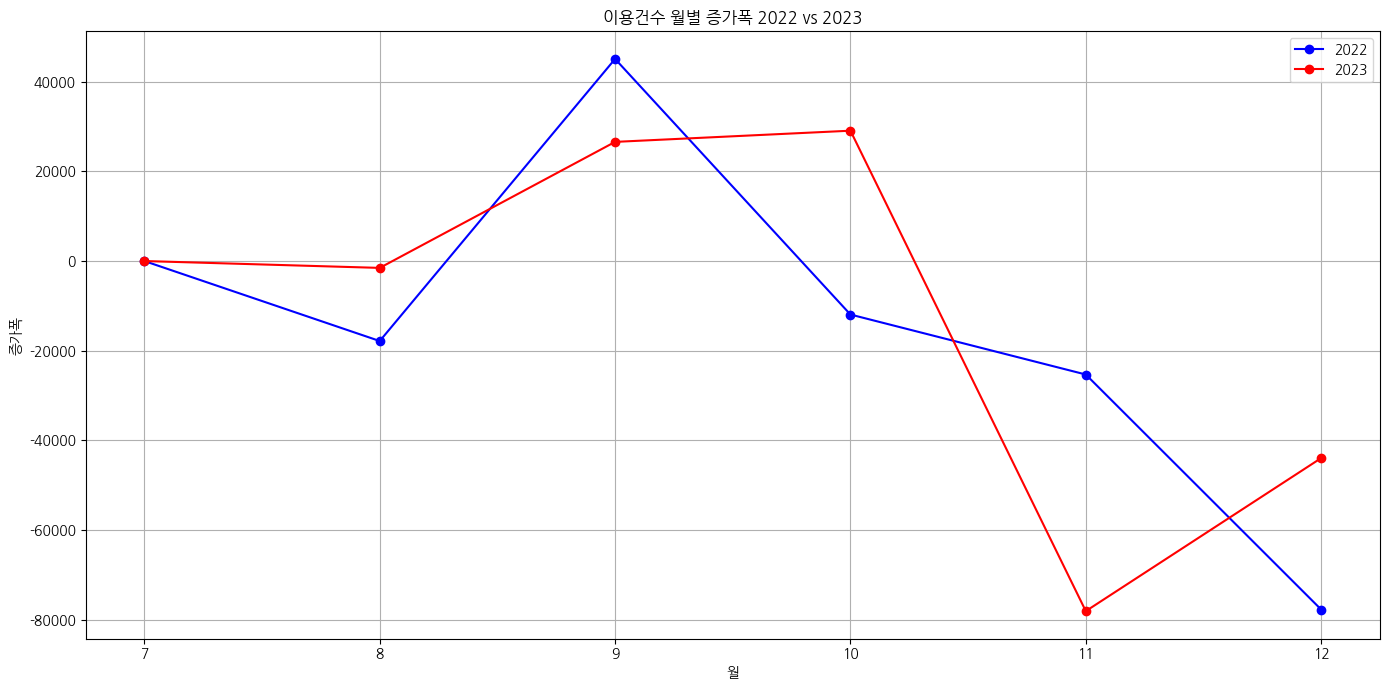

In [50]:
plt.figure(figsize=(14, 7))

plt.plot(monthly_counts_2022['월'], monthly_counts_2022['이용건수_증가폭'], marker='o', label='2022', color='blue')

plt.plot(monthly_counts_2023['월'], monthly_counts_2023['이용건수_증가폭'], marker='o', label='2023', color='red')
plt.title('이용건수 월별 증가폭 2022 vs 2023')
plt.xlabel('월')
plt.ylabel('증가폭')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

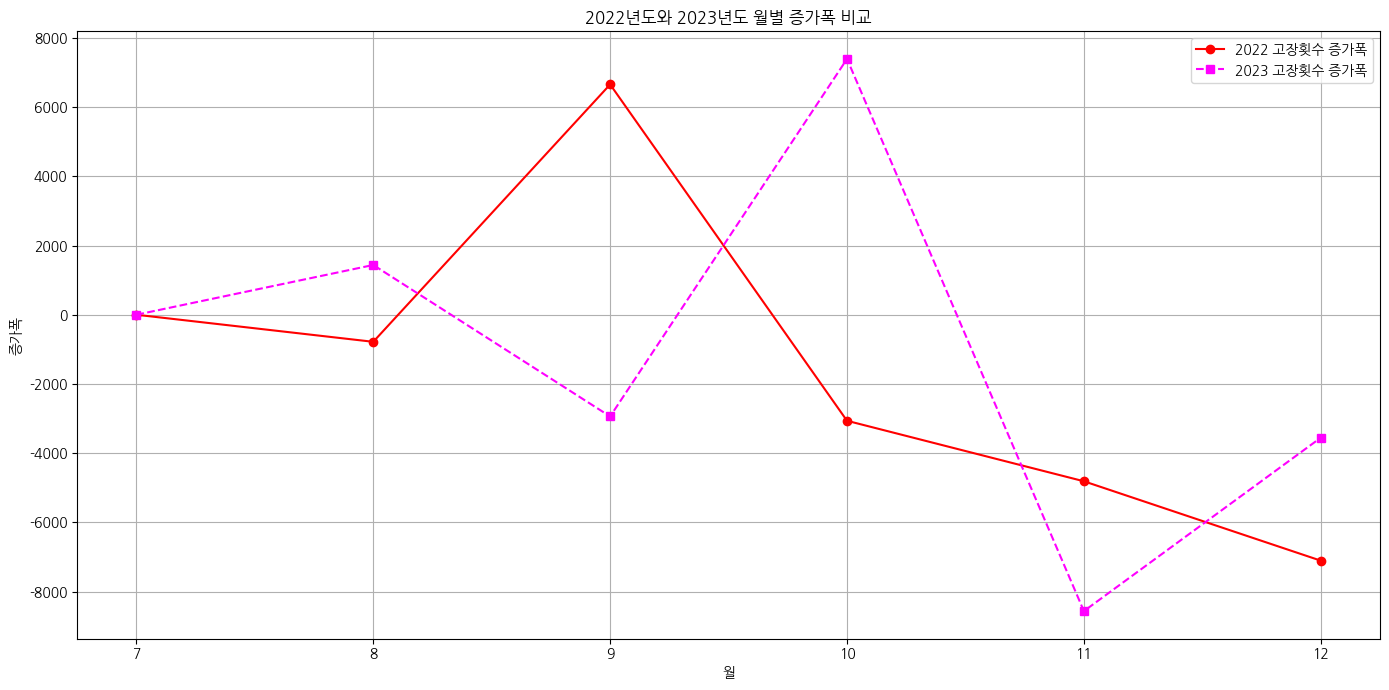

In [51]:
plt.figure(figsize=(14, 7))

plt.plot(monthly_counts_2022['월'], monthly_counts_2022['고장횟수_증가폭'], marker='o', label='2022 고장횟수 증가폭', color='red')

plt.plot(monthly_counts_2023['월'], monthly_counts_2023['고장횟수_증가폭'], marker='s', linestyle='--', label='2023 고장횟수 증가폭', color='magenta')

plt.title('2022년도와 2023년도 월별 증가폭 비교')
plt.xlabel('월')
plt.ylabel('증가폭')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


이용건수와 고장횟수의 상관관계

In [52]:
correlation_2022 = merged_2022[['이용건수', '고장횟수']].corr().iloc[0, 1]
correlation_2023 = merged_2023[['이용건수', '고장횟수']].corr().iloc[0, 1]
print(f"2022년도 이용건수와 고장 횟수 상관관계: {correlation_2022:.2f}")
print(f"2023년도 이용건수와 고장 횟수 상관관계: {correlation_2023:.2f}")


2022년도 이용건수와 고장 횟수 상관관계: 0.97
2023년도 이용건수와 고장 횟수 상관관계: 0.89


In [53]:
corr_2022, p_value_2022 = stats.pearsonr(monthly_counts_2022['이용건수'], monthly_counts_2022['고장횟수'])
corr_2023, p_value_2023 = stats.pearsonr(monthly_counts_2023['이용건수'], monthly_counts_2023['고장횟수'])
print("2022년 이용건수-고장횟수 상관계수:", corr_2022)
print("2022년 이용건수-고장횟수 p-value:", p_value_2022)
print("2023년 이용건수-고장횟수 상관계수:", corr_2023)
print("2023년 이용건수-고장횟수 p-value:", p_value_2023)

2022년 이용건수-고장횟수 상관계수: 0.9720293452024913
2022년 이용건수-고장횟수 p-value: 0.001162594768504942
2023년 이용건수-고장횟수 상관계수: 0.8902266816643759
2023년 이용건수-고장횟수 p-value: 0.017413877927198625


In [54]:
corr_2022, p_value_2022 = stats.pearsonr(monthly_counts_2022['이용건수_증가폭'], monthly_counts_2022['고장횟수_증가폭'])
corr_2023, p_value_2023 = stats.pearsonr(monthly_counts_2023['이용건수_증가폭'], monthly_counts_2023['고장횟수_증가폭'])
print("2022년 이용건수_증가폭-고장횟수 증가폭 상관계수:", corr_2022)
print("2022년 이용건수_증가폭-고장횟수 증가폭 p-value:", p_value_2022)
print("2023년 이용건수_증가폭-고장횟수 증가폭 상관계수:", corr_2023)
print("2023년 이용건수_증가폭-고장횟수 증가폭 p-value:", p_value_2023)

2022년 이용건수_증가폭-고장횟수 증가폭 상관계수: 0.9393661692343989
2022년 이용건수_증가폭-고장횟수 증가폭 p-value: 0.005403233179785503
2023년 이용건수_증가폭-고장횟수 증가폭 상관계수: 0.7867739162499159
2023년 이용건수_증가폭-고장횟수 증가폭 p-value: 0.06335084355995355


In [90]:
shapiro_test_2022 = stats.shapiro(monthly_counts_2022['이용건수'])
shapiro_test_2023 = stats.shapiro(monthly_counts_2023['이용건수'])

print(f"2022년 데이터 Shapiro-Wilk Test: W-statistic = {shapiro_test_2022[0]}, p-value = {shapiro_test_2022[1]}")
print(f"2023년 데이터 Shapiro-Wilk Test: W-statistic = {shapiro_test_2023[0]}, p-value = {shapiro_test_2023[1]}")

2022년 데이터 Shapiro-Wilk Test: W-statistic = 0.8624640974880204, p-value = 0.19778142411056415
2023년 데이터 Shapiro-Wilk Test: W-statistic = 0.9791561257326477, p-value = 0.9472868667650852


p-value가 0.05보다 훨씬 작은 값이 나왔기 때문에 데이터가 정규분포를 따른다고 할 수 있다.

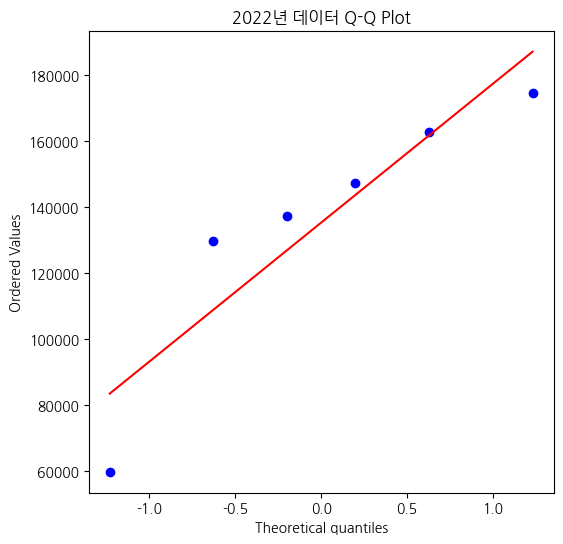

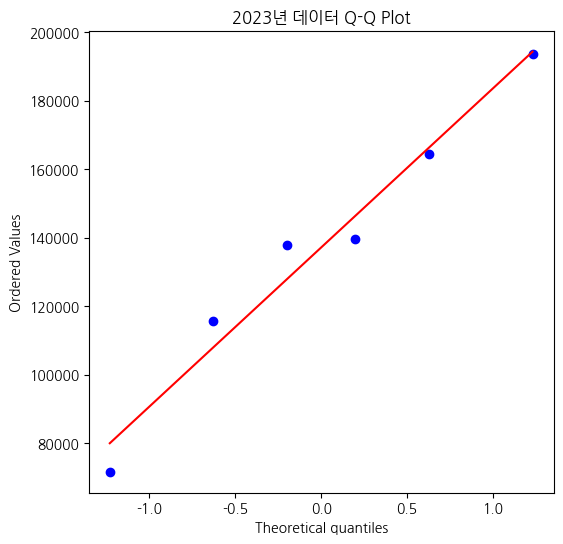

In [89]:
plt.figure(figsize=(6, 6))

# 2022년 데이터에 대한 Q-Q Plot
stats.probplot(monthly_counts_2022['이용건수'], dist="norm", plot=plt)
plt.title("2022년 데이터 Q-Q Plot")
plt.show()

# 2023년 데이터에 대한 Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(monthly_counts_2023['이용건수'], dist="norm", plot=plt)
plt.title("2023년 데이터 Q-Q Plot")
plt.show()

In [71]:
t_stat_use, p_value_use = stats.ttest_ind(monthly_counts_2022['이용건수'],monthly_counts_2023['이용건수'])
#t_stat_broken, p_value_broken = stats.ttest_ind(monthly_counts_2022['고장횟수'], monthly_counts_2023['고장횟수'], equal_var=False)

In [72]:
print("2022-2023년 이용건수 t-tset:", t_stat_use)
print("2022-2023년 이용건수 p-value:", p_value_use)
# print("2022-2023년 고장횟수 t-test:", t_stat_broken)
# print("2022-2023년 고장횟수 p-value:", p_value_broken)

2022-2023년 이용건수 t-tset: -0.07599845039857428
2022-2023년 이용건수 p-value: 0.9409192873258406


요금 인상 시점 t-test

In [77]:
data_2022_sept_to_nov = monthly_counts_2022[(monthly_counts_2022['월'] >= 9) & (monthly_counts_2022['월'] <= 11)]
data_2023_sept_to_nov = monthly_counts_2023[(monthly_counts_2023['월'] >= 9) & (monthly_counts_2023['월'] <= 11)]

In [78]:
t_stat_use, p_value_use = stats.ttest_ind(data_2022_sept_to_nov['이용건수'], data_2023_sept_to_nov['이용건수'])

print(f"2022-2023년 9월-11월 이용건수 t-test: {t_stat_use}")
print(f"2022-2023년 9월-11월 이용건수 p-value: {p_value_use}")

2022-2023년 9월-11월 이용건수 t-test: 0.017367617471719228
2022-2023년 9월-11월 이용건수 p-value: 0.9869751053730142


증가 폭 기준

In [80]:
t_stat_use, p_value_use = stats.ttest_ind(data_2022_sept_to_nov['이용건수_증가폭'],data_2023_sept_to_nov['이용건수_증가폭'])
print(f"2022-2023년 t-test: {t_stat_use}")
print(f"2022-2023년 p-value: {p_value_use}")

2022-2023년 t-test: 0.24379285632311573
2022-2023년 p-value: 0.8193846226194605


In [85]:
increase_ratio_2022 = data_2022_sept_to_nov['이용건수_증가폭'] / data_2022_sept_to_nov['이용건수']
increase_ratio_2023 = data_2023_sept_to_nov['이용건수_증가폭'] / data_2023_sept_to_nov['이용건수']

# t-test 수행
t_stat, p_value = stats.ttest_ind(increase_ratio_2022, increase_ratio_2023)

print(f"2022년과 2023년의 증가 비율에 대한 t-test 결과: t-statistic = {t_stat}, p-value = {p_value}")

2022년과 2023년의 증가 비율에 대한 t-test 결과: t-statistic = 0.3955176781603431, p-value = 0.7126482976578983
